# Colourmaps

Let's look at colourmaps! 

## Load a seismic horizon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seabed = np.load('data/Penobscot_Seabed.npy')

Make a quick plot of -1 × the seabed, as a quick way to get the colourbar the right way up:

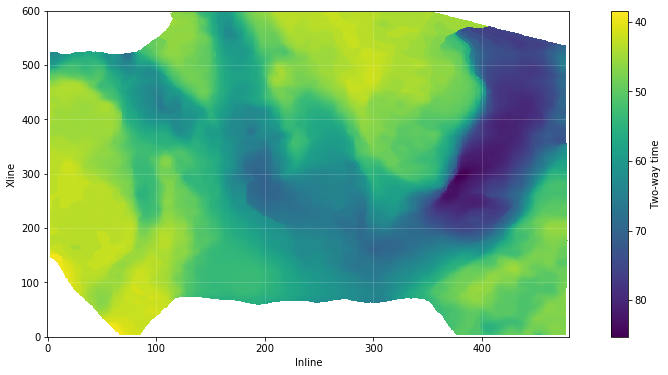

In [3]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.imshow(seabed, aspect=0.5, cmap="viridis_r", origin='lower')
cbar = plt.colorbar(label="Two-way time")
cbar.ax.invert_yaxis()
ax.set_xlabel("Inline")
ax.set_ylabel("Xline")
ax.grid(color='w', alpha=0.2)
plt.show()

## Big giant grid of maplets

OK, we of course should include the annotation of the inlines and crosslines, and the annotated colorbar at the side, and gridlines and scale bars and all the rest of it... but for the purposes of the following experiments, I'm going to leave all that stuff off. Sorry.

First, let's plot the horizon using 12 different colourmaps

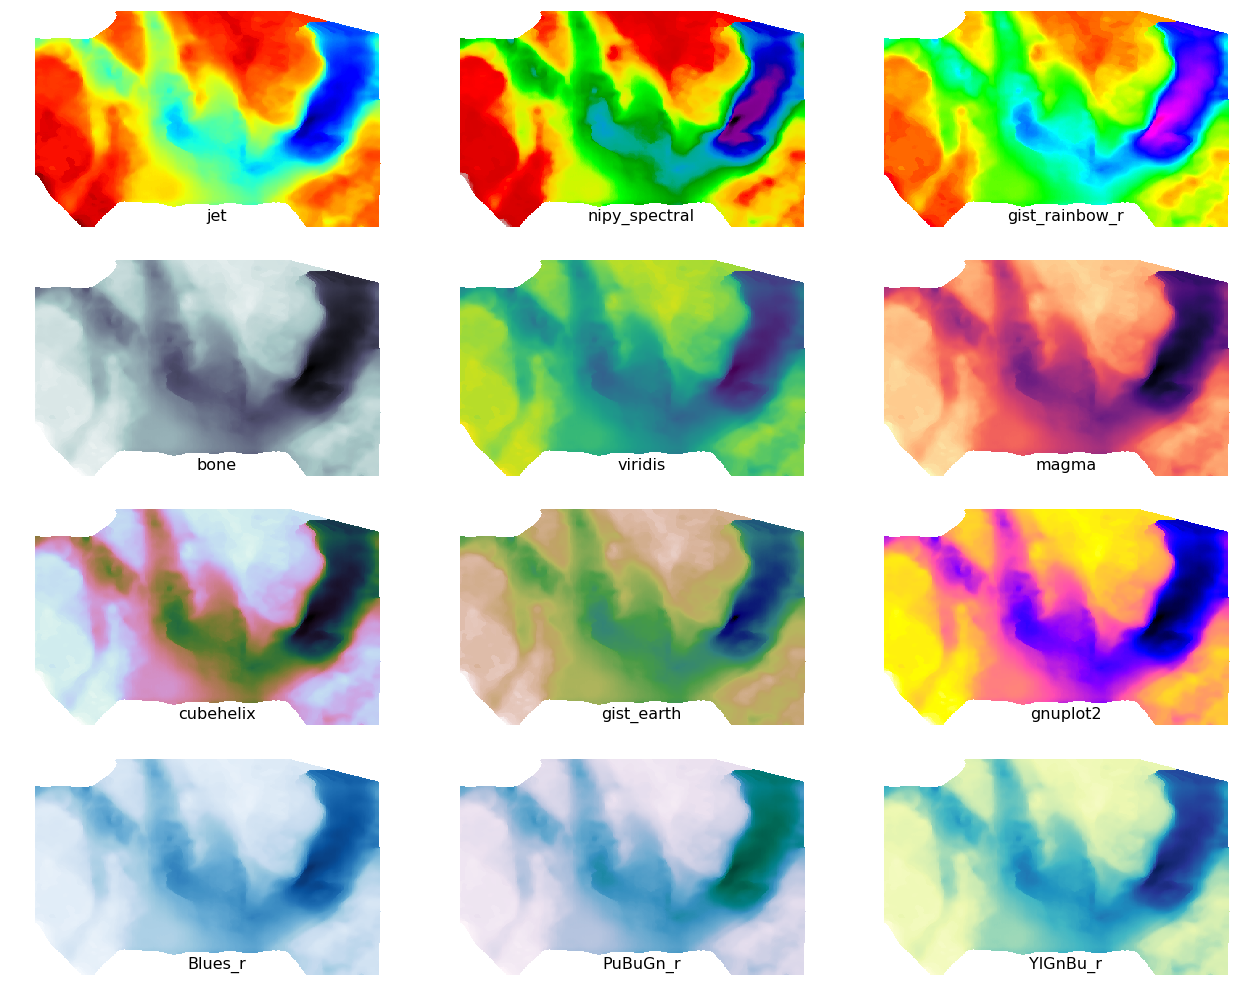

In [4]:
cmaps = [
    'jet', 'nipy_spectral', 'gist_rainbow_r',  # Various rainbow-like.
    'bone', 'viridis', 'magma',                # Perceptually uniform.
    'cubehelix', 'gist_earth', 'gnuplot2',     # Nearly perceptual.
    'Blues_r', 'PuBuGn_r', 'YlGnBu_r',         # Nearly perceptual.
    ]

fig = plt.figure(figsize=(18, 14))
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    plt.imshow(-seabed, aspect=0.5, cmap=cmaps[i], origin='lower')
    ax.axis('off')
    ax.text(253, 22, cmaps[i], ha='center', size=16, color='black')
plt.tight_layout()
plt.show()

## With contours

To plot contours, we need to construct grids of (x, y) coordinates, and we need a list of the levels to plot. We'll do one contour every time sample (4 ms).

In [5]:
xlines, inlines = seabed.shape
x, y = np.arange(inlines), np.arange(xlines)
X, Y = np.meshgrid(x, y)

mi, ma = np.floor(np.nanmin(seabed)), np.ceil(np.nanmax(seabed))
levels = np.arange(mi, ma)

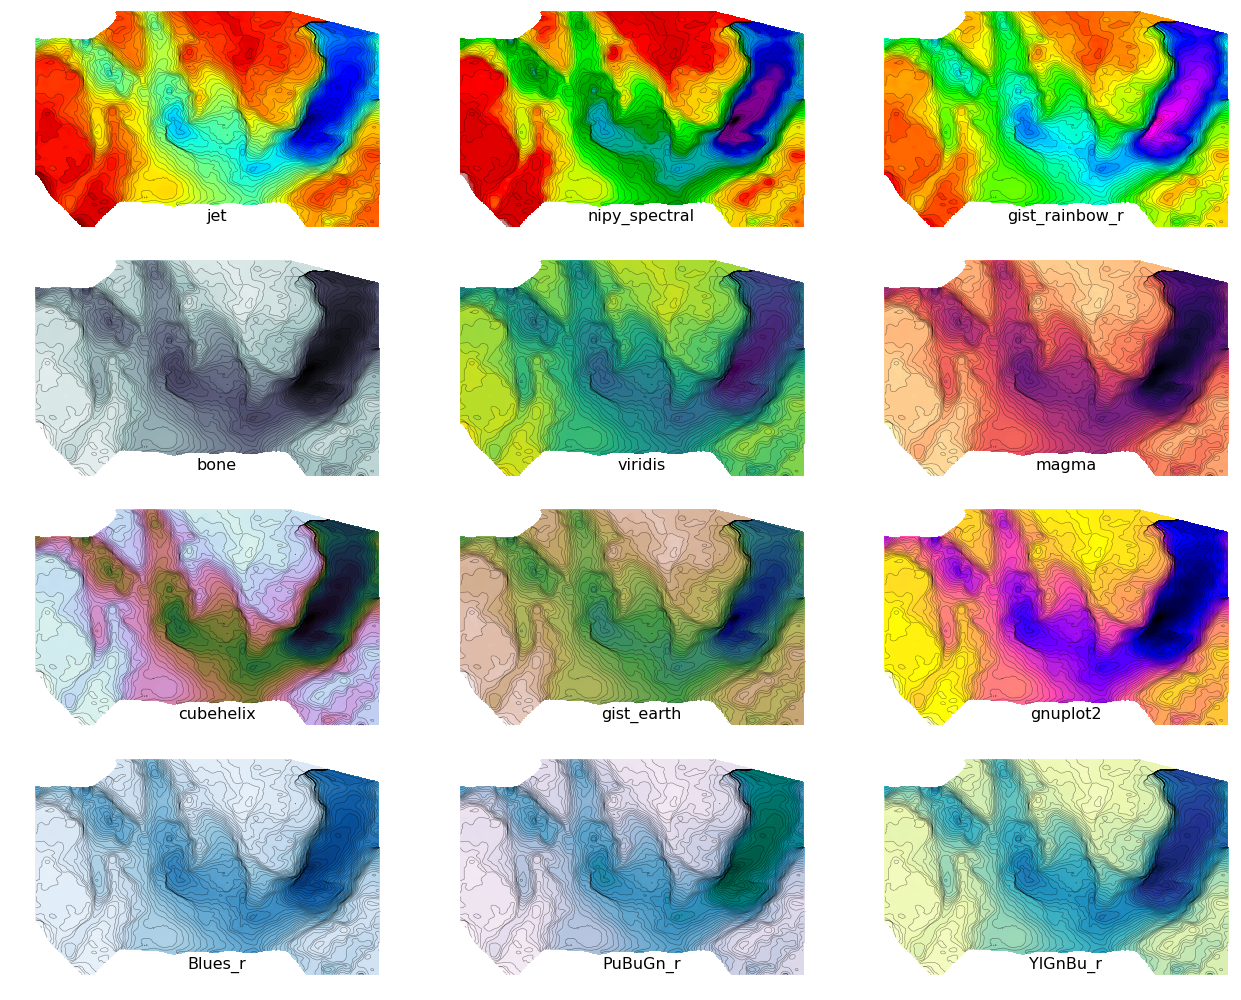

In [6]:
fig = plt.figure(figsize=(18, 14))
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    plt.imshow(-seabed, aspect=0.5, cmap=cmaps[i], origin='lower')
    plt.contour(X, Y, seabed, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
    ax.axis('off')
    ax.text(253, 22, cmaps[i], ha='center', size=16, color='black')
plt.tight_layout()
plt.show()

## With hillshade

Not gonna lie, hillshade can be a little fiddly. In particular, it was a bit of a faff figuring out the `LightSource` azimuth and inclination given that I'm plotting the surface 'upside down' --- large numbers are depressions, not hills. Anyway, I got there in the end.

In [7]:
from matplotlib.colors import LightSource

ls = LightSource(azdeg=225, altdeg=140)
bumps = ls.hillshade(seabed)**0.75     # Taking a root backs it off a bit.

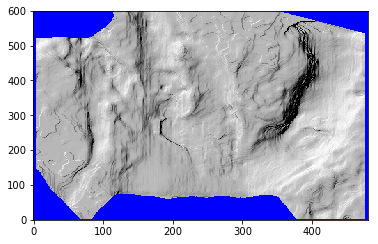

In [8]:
plt.subplot(111, facecolor='b')  # So you can see the colourmap.
plt.imshow(bumps, aspect=0.5, origin='lower', cmap='gray')

Here's where it get's a bit fiddly. I don't want to drop a grey-and-white thing over our horizon. Maplotlib has ways to make a separate blended RGB object out of the hillshade and the horizon, but I'd rather keep them separate. So I'm going to make a new black colourmap, then make it transparent for low (non-shaded) values.

In [9]:
from matplotlib.colors import LinearSegmentedColormap

def make_colormap(seq):
    """
    Converts a sequence of RGB tuples containing floats in the interval (0,1).
    For some reason LinearSegmentedColormap cannot take an alpha channel,
    even though matplotlib colourmaps have one.
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return LinearSegmentedColormap('CustomMap', cdict)

In [10]:
from matplotlib.colors import ListedColormap

def add_alpha(cmap, alpha=None):
    """
    Add an alpha channel (opacity) to a colourmap. Uses a ramp by default.
    Pass an array of 256 values to use that. 0 = transparent; 1 = opaque.
    """
    cmap4 = cmap(np.arange(cmap.N))
    if alpha is None:
        alpha = np.linspace(1, 0, cmap.N)
    cmap4[:,-1] = alpha
    return ListedColormap(cmap4)

In [11]:
kmap = make_colormap([(0,0,0)])
kmap4 = add_alpha(kmap)

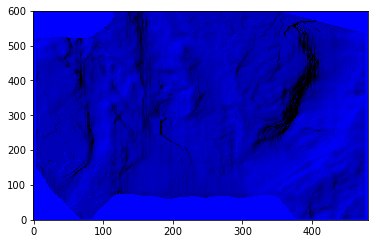

In [12]:
plt.subplot(111, facecolor='b')
plt.imshow(bumps, aspect=0.5, origin='lower', cmap=kmap4)

OK, I like that. Now we can make our plot.

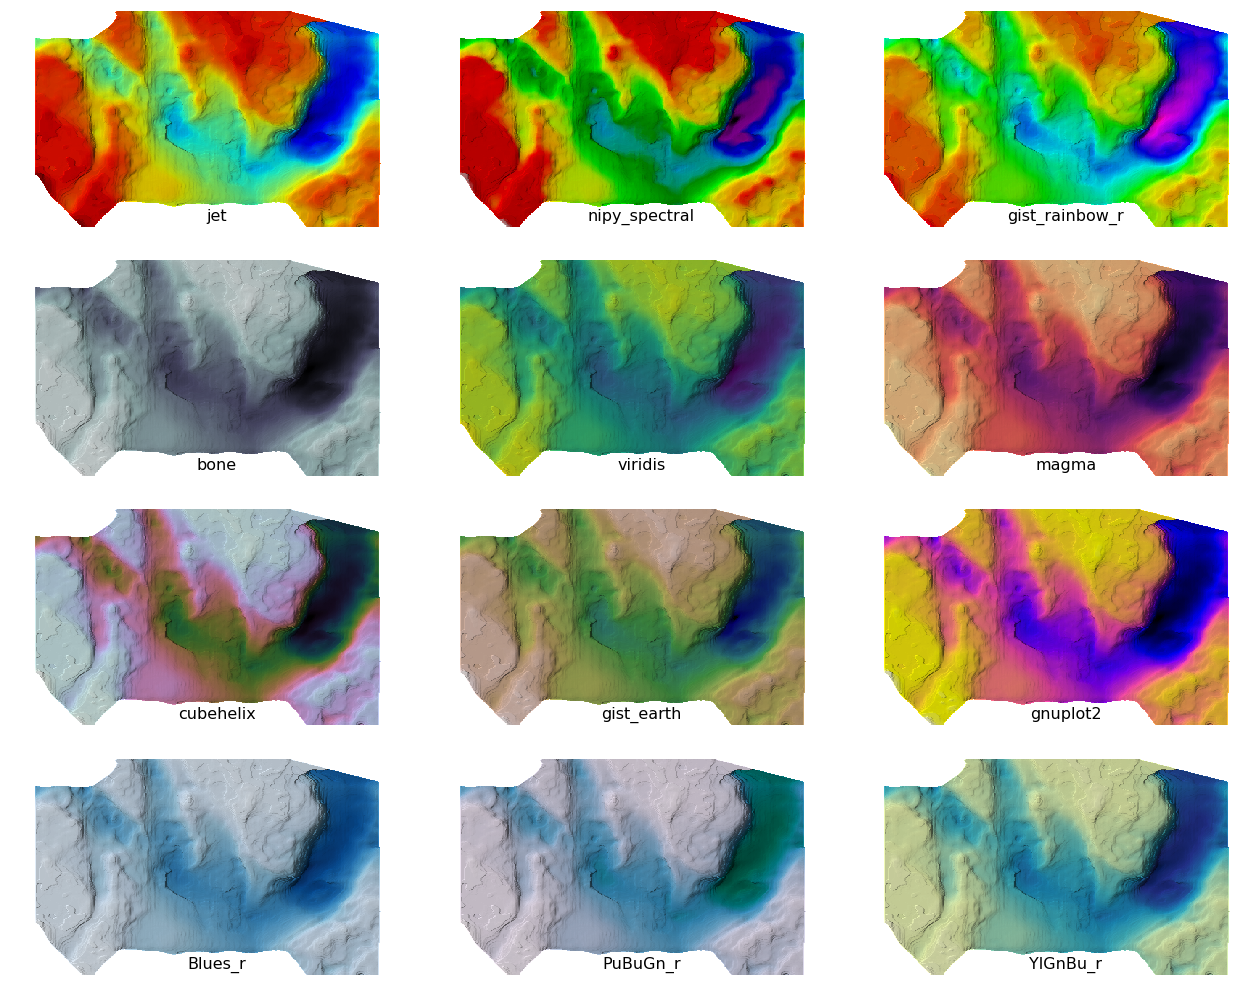

In [13]:
fig = plt.figure(figsize=(18, 14))
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    im = plt.imshow(-seabed, aspect=0.5, cmap=cmaps[i], origin='lower')
    plt.imshow(bumps, cmap=kmap4, aspect=0.5, origin='lower', alpha=0.67)
    ax.axis('off')
    ax.text(253, 22, cmaps[i], ha='center', size=16, color='black')
plt.tight_layout()
plt.show()

## Bring it all together

First let's decompose:

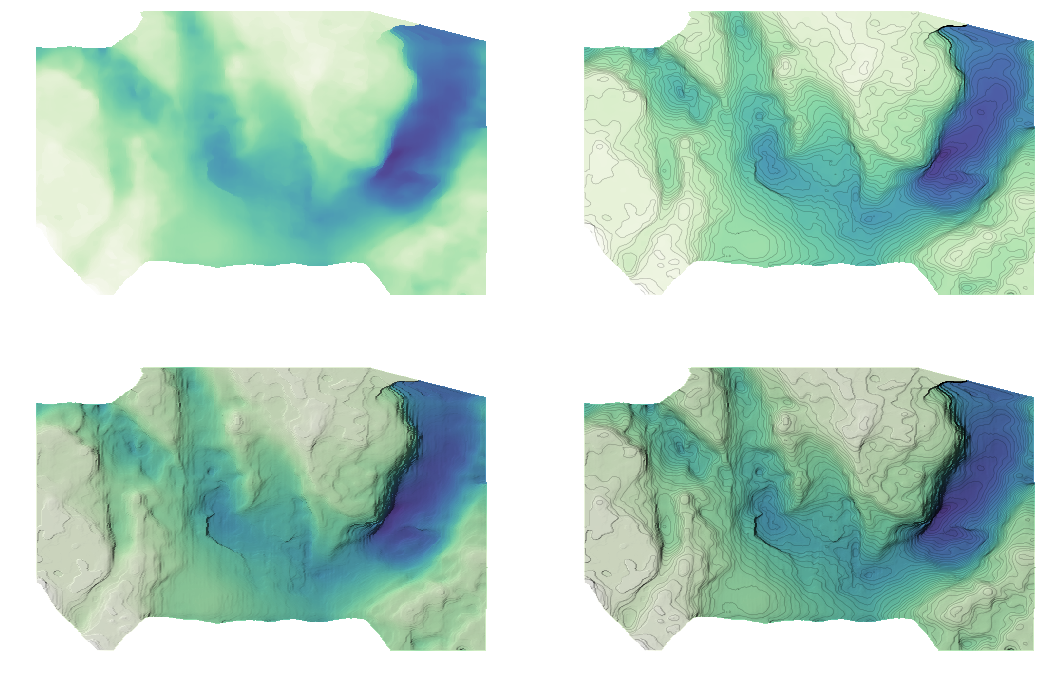

In [14]:
from cubehelix import helix

fig = plt.figure(figsize=(18,12), facecolor='white')

ls = LightSource(azdeg=225, altdeg=140)
bumps = ls.hillshade(seabed)**0.5

params = dict(cmap=helix(0.75, -0.75, reverse=True, min_light=0.3), aspect=0.5, origin='lower')

# Plot everything.
ax0 = fig.add_subplot(221)
ax0.imshow(seabed, **params)
ax0.axis('off')

ax1 = fig.add_subplot(222)
ax1.imshow(seabed, **params)
ax1.contour(X, Y, seabed, levels=levels, linewidths=0.4, colors=[(0,0,0,0.4)])
ax1.axis('off')

ax2 = fig.add_subplot(223)
ax2.imshow(seabed, **params)
ax2.imshow(bumps, cmap=kmap4, aspect=0.5, origin='lower', alpha=0.67)
ax2.axis('off')

ax3 = fig.add_subplot(224)
ax3.imshow(seabed, **params)
ax3.imshow(bumps, cmap=kmap4, aspect=0.5, origin='lower', alpha=0.67)
ax3.contour(X, Y, seabed, levels=levels, linewidths=0.4, colors=[(0,0,0,0.4)])
ax3.axis('off')

plt.show()

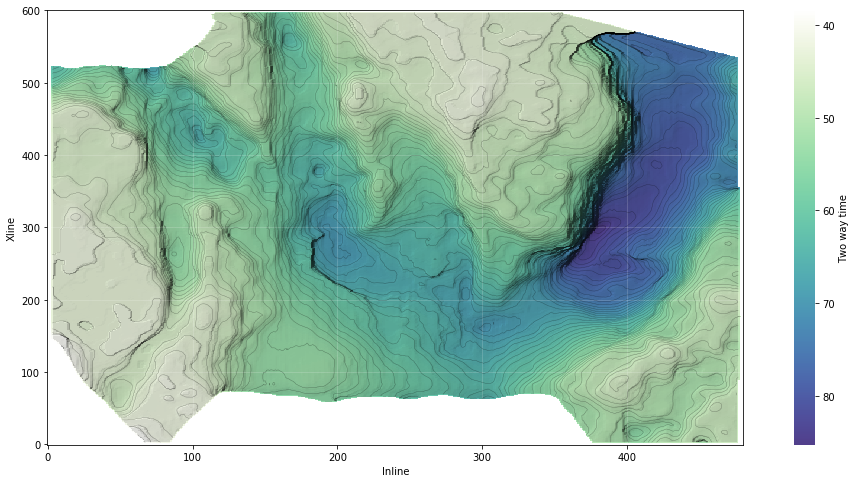

In [15]:
# Finesse the hillshade if you want to.
ls = LightSource(azdeg=225, altdeg=140)
bumps = ls.hillshade(seabed)**0.5 # Sqrt backs it off a bit.

# Make the plot.
fig = plt.figure(figsize=(18,8), facecolor='white')
ax = fig.add_subplot(111)
im = ax.imshow(seabed, cmap=helix(0.75, -0.75, reverse=True, min_light=0.3), aspect=0.5, origin='lower')
ax.imshow(bumps, cmap=kmap4, aspect=0.5, origin='lower', alpha=0.67)
cb = plt.colorbar(im, label="Two way time")
cb.ax.invert_yaxis()
cb.outline.set_visible(False)
ax.contour(X, Y, seabed, levels=levels, linewidths=0.4, colors=[(0,0,0,0.4)])
ax.set_xlabel("Inline")
ax.set_ylabel("Xline")
ax.grid(color='w', alpha=0.2)

plt.show()

## Comparison with spectrum

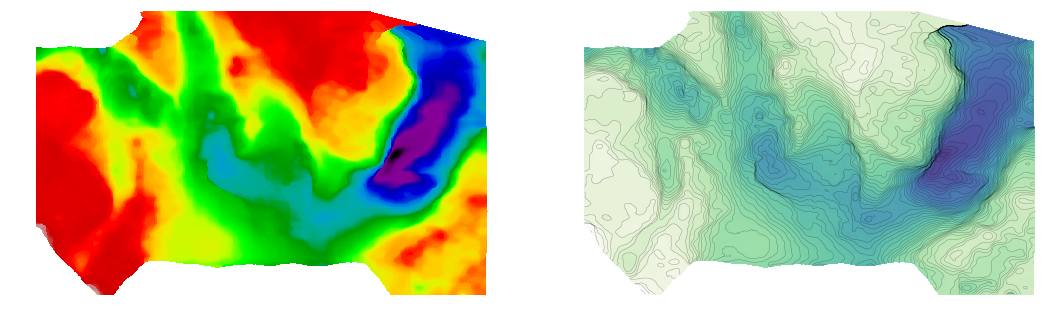

In [16]:
fig = plt.figure(figsize=(18,12), facecolor='white')

ax0 = fig.add_subplot(221)
ax0.imshow(seabed, cmap='nipy_spectral_r', aspect=0.5, origin='lower')
ax0.axis('off')

ax1 = fig.add_subplot(222)
ax1.imshow(seabed, cmap=helix(0.75, -0.75, reverse=True, min_light=0.3), aspect=0.5, origin='lower')
ax1.contour(X, Y, seabed, levels=levels, linewidths=0.4, colors=[(0,0,0,0.4)])
ax1.axis('off')

plt.show()

<hr />

&copy; Agile Scientific 2017 &mdash; licensed CC-BY